/tmp/ipykernel_98652/2389348095.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = pd.to_datetime(data['id'], errors='ignore')
/tmp/ipykernel_98652/2389348095.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))


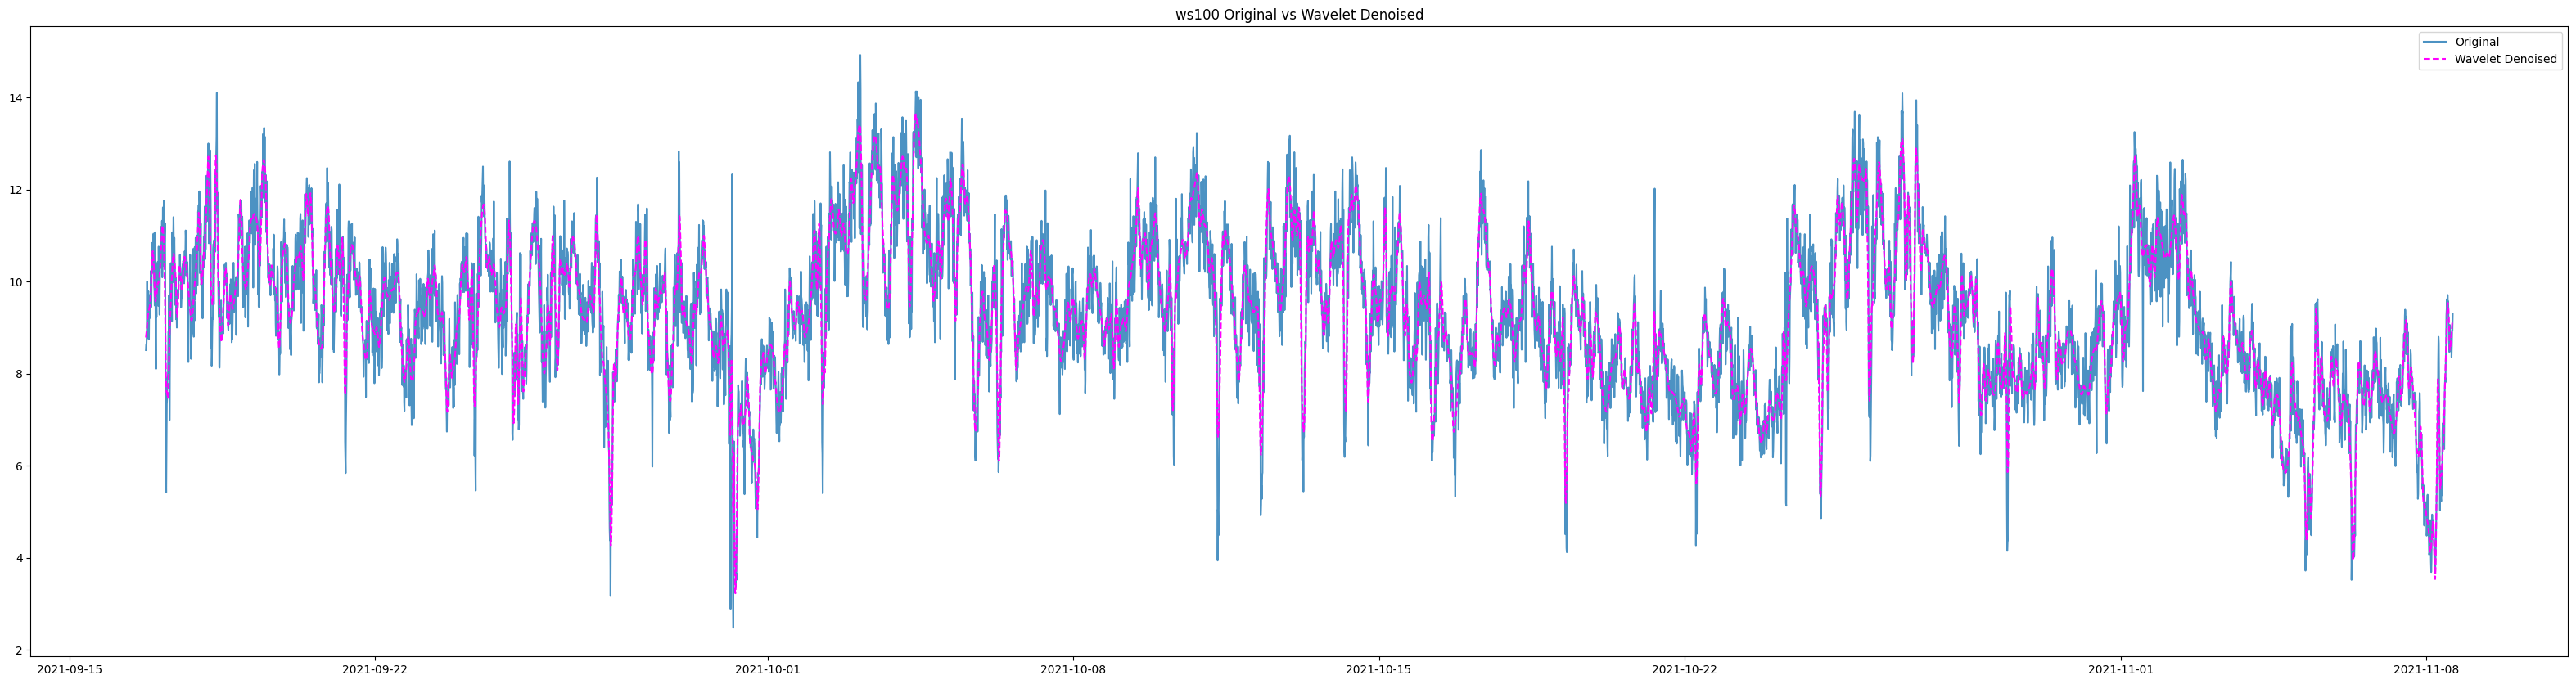

In [5]:
# %% Importação das Bibliotecas Necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pywt  # Biblioteca para Wavelet Transform
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MultiHeadAttention, Bidirectional, LSTM, LayerNormalization, RepeatVector, Dense, Concatenate, TimeDistributed, Lambda, Conv1D, MaxPooling1D, Dropout, Add

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# %% Leitura e Preparação dos Dados
data = pd.read_csv("dataset.csv")
data.index = pd.to_datetime(data['id'], errors='ignore')
data.index = data['id'].apply(lambda x: pd.to_datetime(str(x).split('.')[0], errors='ignore'))

variables = pd.DataFrame(index=data.index)

# Função para Suavização usando Wavelet Transform
def wavelet_denoising(signal, wavelet='db4', level=3):
    coeffs = pywt.wavedec(signal, wavelet, mode='symmetric', level=level)
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeffs[1:]]
    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric')
    return reconstructed_signal

# Aplicação do Wavelet Denoising às Colunas Desejadas
for col in ['ws100', 'ws80', 'ws120', 'temp', 'humid', 'wdisp100', 'wdir100']:
    if col in data.columns:
        denoised_signal = wavelet_denoising(data[col].values)
        variables[f'{col}_wavelet'] = denoised_signal[:len(data)]  # Garantir que o tamanho seja consistente
    else:
        raise ValueError(f"A coluna {col} não existe no dataset.")

# Escalonamento dos Dados
scaler_ws100 = MinMaxScaler()
variables_scaled_ws100 = scaler_ws100.fit_transform(variables[['ws100_wavelet']])

scaler_other = MinMaxScaler()
variables_scaled_other = scaler_other.fit_transform(variables.drop(columns=['ws100_wavelet']))

variables_scaled = np.hstack((variables_scaled_ws100, variables_scaled_other))
variables_scaled = pd.DataFrame(
    variables_scaled, 
    columns=variables.columns, 
    index=variables.index
)

# Plotagem para Comparação
plt.figure(figsize=(40, 10))
plt.plot(data.index, data['ws100'], label='Original', alpha=0.8)
plt.plot(variables.index, variables['ws100_wavelet'], label='Wavelet Denoised', linestyle='--', color='magenta')
plt.title('ws100 Original vs Wavelet Denoised')
plt.legend()
plt.show()

Model: "Enhanced_BiLSTM_Seq2Seq_with_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 36, 7)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 36, 64)    │      1,408 │ encoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 18, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 18, 96)    │     43,392 │ max_pooling1d_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout_0   │ (None, 18, 96)    │          0 │ bidirectional_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_residual_0  │ (None, 18, 96)    │      6,240 │ max_pooling1d_2[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_norm_0      │ (None, 18, 96)    │        192 │ encoder_dropout_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 18, 96)    │          0 │ encoder_residual… │
│                     │                   │            │ encoder_norm_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 96)        │          0 │ add_4[0][0]       │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 6, 96)     │          0 │ get_item_2[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm_0      │ (None, 6, 96)     │     74,112 │ repeat_vector_2[… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout_0   │ (None, 6, 96)     │          0 │ decoder_lstm_0[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_norm_0      │ (None, 6, 96)     │        192 │ decoder_dropout_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 6, 96)     │          0 │ repeat_vector_2[… │
│                     │                   │            │ decoder_norm_0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 6, 96)     │    111,552 │ add_4[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_5[0][0],      │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_dense     │ (None, 6, 48)     │      4,656 │ multihead_attent… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 6, 144)    │          0 │ add_5[0][0],    

 Total params: 241,889 (944.88 KB)

 Trainable params: 241,889 (944.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - loss: 0.1480 - mse: 1.2899 - val_loss: 0.0244 - val_mse: 0.0465 - learning_rate: 1.0000e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0438 - mse: 0.1333 - val_loss: 0.0130 - val_mse: 0.0197 - learning_rate: 1.0000e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 0.0222 - mse: 0.0476 - val_loss: 0.0067 - val_mse: 0.0072 - learning_rate: 1.0000e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 0.0090 - mse: 0.0121 - val_loss: 0.0047 - val_mse: 0.0034 - learning_rate: 1.0000e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0065 - mse: 0.0071 - val_loss: 0.0048 - val_mse: 0.0037 - learning_rate: 1.0000e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0060 - mse: 0.0063 - val_loss: 0.0046 - val_mse: 0.0033 - learning_rate: 1.0000e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 0.0054 - mse: 0.0051 - val_loss: 0.0048 - v

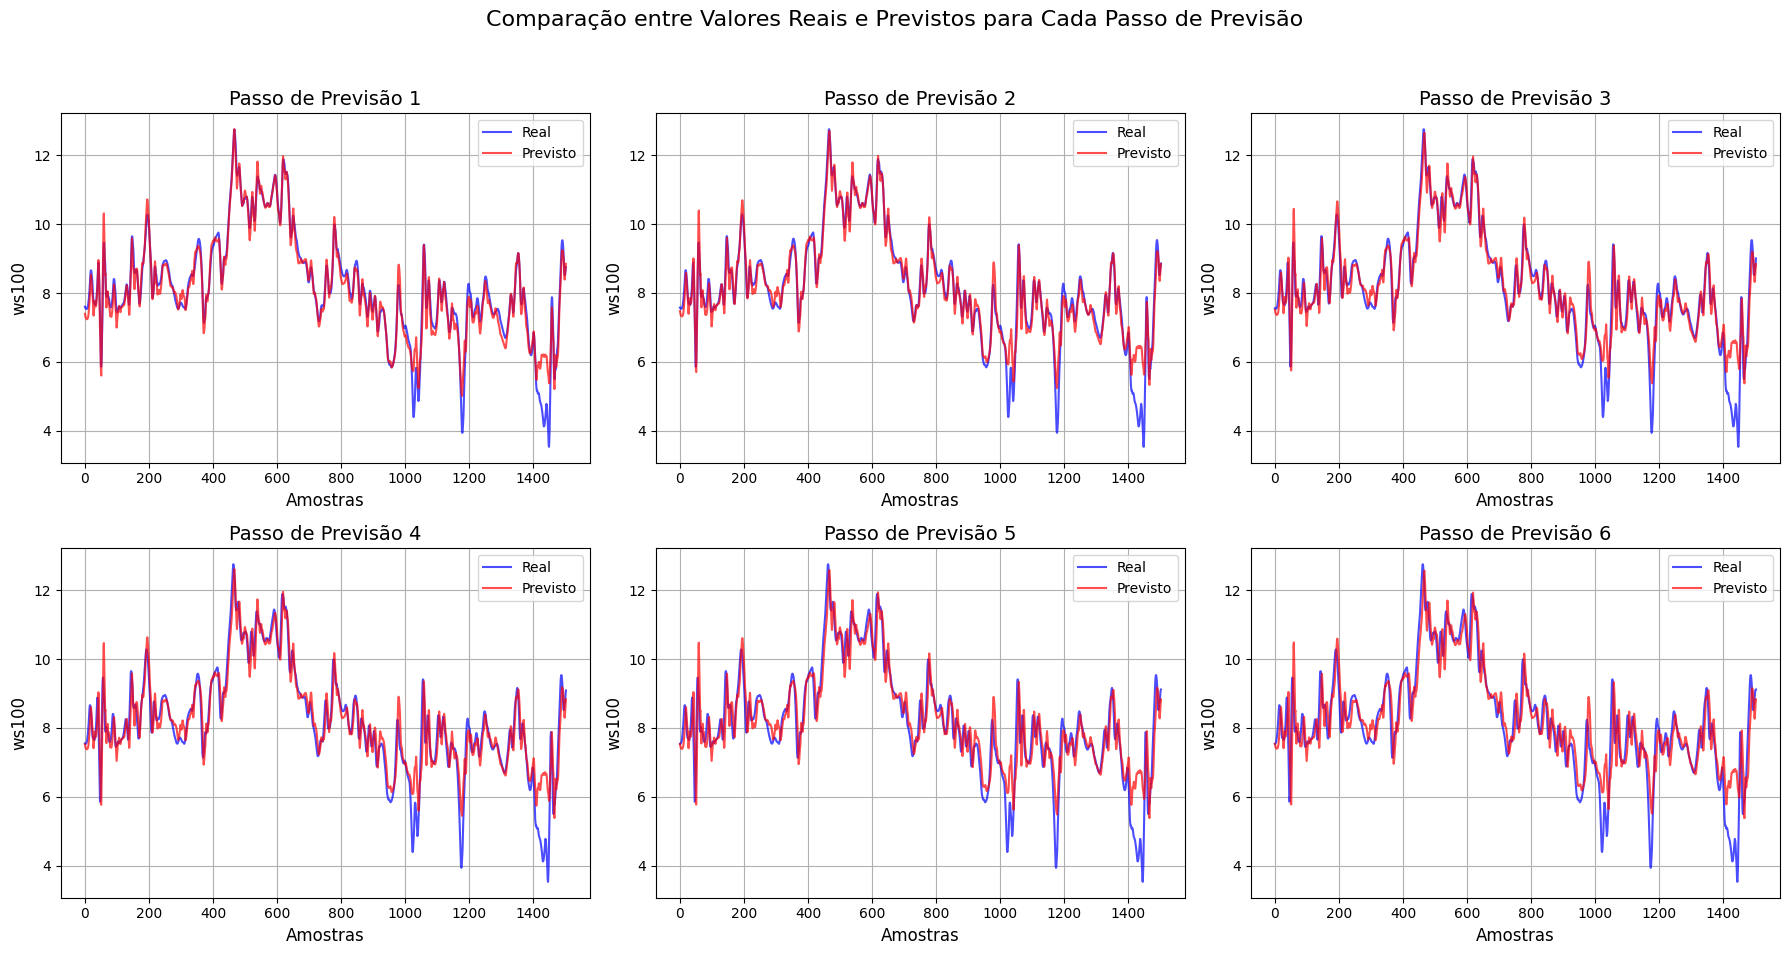

In [6]:
# %% Preparação dos Dados para o Modelo
input_steps = 36
output_steps = 6

def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps)])
        y.append(data[(i + input_steps):(i + input_steps + output_steps), 0])  
    return np.array(X), np.array(y)

data_array = variables_scaled.values

X, y = create_sequences(data_array, input_steps, output_steps)

split_index = int(X.shape[0] * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# %% Definição do Modelo LSTM com Atenção
def custom_huber_loss(y_true, y_pred):
    delta = 0.2
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

def build_model(input_steps, num_features, output_steps):
    num_layers = 1  # Aumentado de 1 para 2
    units = 48     # Aumentado de 100 para 128
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)  # Taxa de aprendizado ajustada
    
    # Encoder
    encoder_inputs = Input(shape=(input_steps, num_features), name='encoder_inputs')
    
    # Camadas Convolucionais para extração de características locais
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(encoder_inputs)
    x = MaxPooling1D(pool_size=2)(x)
    encoder_outputs = x
    
    for i in range(num_layers):
        lstm = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            kernel_regularizer=l2(1e-5),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        dropout = Dropout(0.2, name=f'encoder_dropout_{i}')(lstm)
        norm = LayerNormalization(name=f'encoder_norm_{i}')(dropout)
        
    # Projete o encoder_outputs para corresponder à dimensão do LSTM
    residual = Dense(units * 2, activation='linear', name=f'encoder_residual_{i}')(encoder_outputs)
    
    # Adicione o residual projetado
    encoder_outputs = Add()([residual, norm])
    
    context_vector = encoder_outputs  
    
    # Decoder
    decoder_inputs = RepeatVector(output_steps)(encoder_outputs[:, -1, :]) 
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_lstm = LSTM(
            units=units * 2,
            return_sequences=True,
            kernel_regularizer=l2(1e-5),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_dropout = Dropout(0.2, name=f'decoder_dropout_{i}')(decoder_lstm)
        decoder_norm = LayerNormalization(name=f'decoder_norm_{i}')(decoder_dropout)
        decoder_outputs = Add()([decoder_outputs, decoder_norm])  # Conexão residual
    
    # Mecanismo de Atenção
    attention_layer = MultiHeadAttention(num_heads=6, key_dim=units, name='multihead_attention')  # Mais cabeças
    attention_output = attention_layer(query=decoder_outputs, value=context_vector, key=context_vector)
    
    attention_dense = Dense(units, activation='tanh', name='attention_dense')(attention_output)
    
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_dense])
    
    # Camadas de Saída
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=-1))(outputs)  
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Enhanced_BiLSTM_Seq2Seq_with_Attention')
    
    # Compilação do Modelo
    model.compile(
        optimizer=optimizer,
        loss=custom_huber_loss,  # Certifique-se de que 'custom_huber_loss' está definido
        metrics=['mse']
    )
    
    return model

# %% Construção e Treinamento do Modelo
num_features = X_train.shape[2]
model = build_model(input_steps, num_features, output_steps)

model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train, 
    epochs=100,  
    batch_size=32, 
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

# %% Avaliação do Modelo
model.load_weights('best_model.h5.keras')

y_pred = model.predict(X_test)

y_test_inversed = scaler_ws100.inverse_transform(y_test)
y_pred_inversed = scaler_ws100.inverse_transform(y_pred)

# %% Visualização dos Resultados
output_steps = 6

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Comparação entre Valores Reais e Previstos para Cada Passo de Previsão', fontsize=16)

for step in range(output_steps):
    row = step // 3
    col = step % 3
    ax = axes[row, col]
    
    real = y_test_inversed[:, step]
    pred = y_pred_inversed[:, step]
    
    ax.plot(real, label='Real', color='blue', alpha=0.7)
    ax.plot(pred, label='Previsto', color='red', alpha=0.7)
    
    ax.set_title(f'Passo de Previsão {step + 1}', fontsize=14)
    ax.set_xlabel('Amostras', fontsize=12)
    ax.set_ylabel('ws100', fontsize=12)
    ax.legend()
    ax.grid(True)
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
plt.show()